In [ ]:
#written by @caramnix on 8.10.21 

In [10]:
from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
import geopandas as gpd
import pandas as pd
import numpy
import networkx as nx
import maup
import os
import json
from collections import Counter

from gerrychain import MarkovChain
from gerrychain.constraints import no_vanishing_districts, single_flip_contiguous, no_more_discontiguous, UpperBound, within_percent_of_ideal_population
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
import matplotlib.pyplot as plt
from gerrychain import constraints

from networkx import is_connected, connected_components
from gerrychain.constraints.contiguity import contiguous_components, contiguous, number_of_contiguous_parts

In [11]:
#generate new_list for indexing purposes 
blocks = gpd.read_file("/home/nix.39/SC_edgerry/shapefiles/2019blocks_MN_money.shp")
blocks = blocks.to_crs(epsg=26914)
sd = gpd.read_file("/home/nix.39/SC_edgerry/shapefiles/school_district_joined/school_district_joined.shp")
sd= sd.to_crs(epsg=26914)
az = gpd.read_file("/home/nix.39/SC_edgerry/shapefiles/fixed_attendance_zone/fixed_attendance_zone.shp")
az= az.to_crs(epsg=26914)
assignment = maup.assign(az, sd)
d = Counter(assignment)
new_list = list([item for item in d if d[item]>1])

In [12]:
for index in new_list: #numbering right here! 
    print(index) 

3
4
5
6
7
8
9
12
16
19
32
34
44
49
52
53
54
56
57
58
59
62
68
76
77
78
79
80
81
83
84
85
87
88
100
106
110
112
130
134
139
153
173
174
175
176
177
181
182
186
191
192
195
199
200
201
204
209
211
212
215
231
233
234
243
245
248
250
252
260
262
268
284
297
306
316
323
329
330


In [3]:
#testing 
index=7
blocks_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/blocks_AZ7/blocks_AZ7.shp")
blocks_i = blocks_i.to_crs(epsg=26915)
a_path = "AZ_" + str(index) +"/AZ_" + str(index) +".shp"
attendance_zone_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + a_path)
attendance_zone_i= attendance_zone_i.to_crs(epsg=26915)
blocks_i["tot18"] = pd.to_numeric(blocks_i["tot18"])
    
blocks_i["white18"] = pd.to_numeric(blocks_i["white18"])
blocks_i["black18"] = pd.to_numeric(blocks_i["black18"])
    
    #fix nonnumeric entries 
for j in range(0,len(blocks_i)): 
    try:
        blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
    except ValueError as error:
            #print("here")
        error_string = str(error)
        error_list= error_string.split(" ")
        index= int(error_list[-1])
        blocks_i.loc[index, 'HHincome20'] = 0
            #print(error_string)

    try:
        blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
    except ValueError as error:
        error_string = str(error)
        error_list= error_string.split(" ")
        index= int(error_list[-1])
        blocks_i.loc[index, 'HHincome_1'] = 0
            #print(error_string)
            
blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
    
    #great now everythign is numeric 
    
    #assign blocks to AZ's
assignment_i = maup.assign(blocks_i, attendance_zone_i)
blocks_i["AZ"] = assignment_i
    
blocks_i = Graph.from_geodataframe(blocks_i) 


/home/nix.39/.local/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/home/nix.39/.local/lib/python3.7/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSe

In [4]:
partition_test= Partition(blocks_i, assignment_i)

In [5]:
contiguous(partition_test)

False

In [82]:
contiguous_components(partition_test)
#Return the connected components of each of the subgraphs of the partsof the partition

{0: [<networkx.classes.graphviews.SubGraph at 0x2aeadc30ce48>],
 1: [<networkx.classes.graphviews.SubGraph at 0x2aeadc30cef0>],
 2: [<networkx.classes.graphviews.SubGraph at 0x2aeadc30e550>,
  <networkx.classes.graphviews.SubGraph at 0x2aeadc307400>]}

In [83]:
number_of_contiguous_parts(partition_test) #ah, this should be 3! 
#Return the number of non-connected assignment subgraphs.

2

In [ ]:
for i in range(0,len(contiguous_components(initial_partition_i))): 
    az_oi= 

In [25]:
blocks_i.islands #so NO islands 

set()

In [75]:
components = list(connected_components(blocks_i)) #can you do som

In [74]:
[len(c) for c in components]

[1098]

In [6]:
#testing 
initial_partition_i = Partition(
        blocks_i,
        assignment="AZ",
        updaters={
            "cut_edges": cut_edges,
            "population": Tally("tot18", alias="population"),
            "black_population": Tally("black18", alias= "black_population"),
            "white_population": Tally("white18", alias= "white_population"),
            "HHincome2019": Tally("HHincome20", alias ="HHincome2019"),
            "HHincome2019Error": Tally("HHincome_1", alias="HHincome2019Error")
        }
    )


#"ValueError: The given initial_state is not valid according is_valid. The failed constraints were: number_of_contiguous_parts"



In [86]:
outer_dict ={} 
ct= 0 
allAssignments = {0: chain.state.assignment}
for partition in chain:
    dict_i = {"HHincome2019" : partition["HHincome2019"],
            #"cut_edges": partition["cut_edges"],
              "population":  partition["population"],
              "black_population": partition["black_population"],
              "white_population": partition["white_population"],
              "HHincome2019Error": partition["HHincome2019Error"]}
    outer_dict[ct] = dict_i
    ct+=1 

In [88]:
allAssignments

{0: <Assignment [476 keys, 2 parts]>}

In [87]:
initial_partition_i

<Partition [3 parts]>

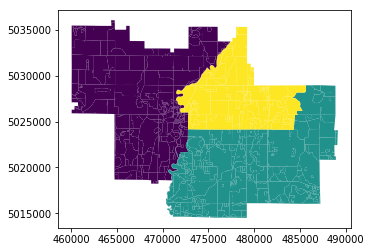

In [89]:
initial_partition_i.plot()

In [ ]:
allAssignments

In [ ]:
import networkx as nx

In [40]:
parts = initial_partition_i.assignment.parts
sum(1 for part in parts if nx.is_connected(initial_partition_i.subgraphs[part]))


3

In [41]:
parts = initial_partition_i.assignment.parts
summ =0
for part in parts: 
    print(type(initial_partition_i.subgraphs[part]))
    print(nx.is_empty(initial_partition_i.subgraphs[part]))
    if nx.is_connected(initial_partition_i.subgraphs[part]):
        summ +=1
        print(nx.is_connected(initial_partition_i.subgraphs[part]))
summ



<class 'networkx.classes.graphviews.SubGraph'>
False
True
<class 'networkx.classes.graphviews.SubGraph'>
False
True
<class 'networkx.classes.graphviews.SubGraph'>
False
True


3

In [15]:
parts

{0: frozenset({0,
            1,
            22,
            23,
            28,
            29,
            30,
            42,
            43,
            44,
            57,
            62,
            86,
            87,
            109,
            123,
            130,
            148,
            149,
            150,
            151,
            152,
            153,
            170,
            172,
            175,
            188,
            189,
            194,
            195,
            197,
            198,
            199,
            201,
            202,
            203,
            204,
            207,
            248,
            249,
            254,
            255,
            288,
            289,
            290,
            293,
            348,
            398,
            399,
            400,
            401,
            407,
            434,
            447,
            449,
            450,
            460,
            481,
            482,
          

In [6]:
compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]),
        2*len(initial_partition_i["cut_edges"])
    )
    #pop_constraint = constraints.within_percent_of_ideal_population(initial_partition_i, 0.87)

    #build chain! 
    #try: 
chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[no_more_discontiguous, compactness_bound],#single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition_i,
    total_steps=3000 ##TOT STEPS HERE 
    )



NameError: name 'initial_partition_i' is not defined

In [33]:
if callable(constraints):
    is_valid = constraints
        

In [34]:
constraints

<module 'gerrychain.constraints' from '/home/nix.39/.local/lib/python3.7/site-packages/gerrychain/constraints/__init__.py'>

In [35]:
is_valid

NameError: name 'is_valid' is not defined

In [17]:
from matplotlib import pylab as pl

In [18]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

In [127]:
import random
random.seed(19)

TOTALSTEPSOFCHAIN= 5000

list_to_make_figs = [] #[4,5,6,8,9,12,16,329,330]  #should these be 01? 

#skipped 7, 10,19,20, 25, 28, 34, 37, 39, 47, 48, 49, 50, 51, 54, 55, 59, 60, 63, 64,65, 66, 68, 69, 70, 74, 75, 78(parts/contig error) + 11, 15, 16, 17, 24  (27 was weird), 29 (33 weird), (41 weird), 43, 53, 62(cut short error)
for i in range(0,len(new_list)):  
    index = new_list[i]
    
    #read in files 
    b_path = "blocks_AZ" + str(index) +"/blocks_AZ" + str(index) +".shp"
    print(b_path)
    blocks_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + b_path)
    blocks_i = blocks_i.to_crs(epsg=26915)
    a_path = "AZ_" + str(index) +"/AZ_" + str(index) +".shp"
    attendance_zone_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + a_path)
    attendance_zone_i= attendance_zone_i.to_crs(epsg=26915)
    blocks_i["tot18"] = pd.to_numeric(blocks_i["tot18"])
    
    blocks_i["white18"] = pd.to_numeric(blocks_i["white18"])
    blocks_i["black18"] = pd.to_numeric(blocks_i["black18"])
    
    #fix nonnumeric entries 
    for j in range(0,len(blocks_i)): 
        try:
            blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
        except ValueError as error:
            #print("here")
            error_string = str(error)
            error_list= error_string.split(" ")
            index= int(error_list[-1])
            blocks_i.loc[index, 'HHincome20'] = 0
            #print(error_string)

        try:
            blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
        except ValueError as error:
            error_string = str(error)
            error_list= error_string.split(" ")
            index= int(error_list[-1])
            blocks_i.loc[index, 'HHincome_1'] = 0
            #print(error_string)
            
    blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
    blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
    
    #great now everythign is numeric 
    
    #assign blocks to AZ's
    assignment_i = maup.assign(blocks_i, attendance_zone_i)
    blocks_i["AZ"] = assignment_i
    
    blocks_i = Graph.from_geodataframe(blocks_i) 
    
    #deal with contiguity--albiet poorly
    components = list(connected_components(blocks_i))
    print([len(c) for c in components])
    #print(components)
    print(len(components))
    if len(components) != 1:
        print("in here, len >1")
        biggest_component_size = max(len(c) for c in components)
        problem_components = [c for c in components if len(c) != biggest_component_size]
        for component in problem_components:
            for node in component:
                blocks_i.remove_node(node)
        print(str(index) + ": has islands ")

    #create inital partition 
    #initial_partition_i = build_ip(blocks_i)
    initial_partition_i = Partition(
        blocks_i,
        assignment="AZ",
        updaters={
            #"cut_edges": cut_edges,
            "population": Tally("tot18", alias="population"),
            "black_population": Tally("black18", alias= "black_population"),
            "white_population": Tally("white18", alias= "white_population"),
            "HHincome2019": Tally("HHincome20", alias ="HHincome2019"),
            "HHincome2019Error": Tally("HHincome_1", alias="HHincome2019Error")
        }
    )

    #set bounds 
    compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]),
        2*len(initial_partition_i["cut_edges"])
    )
    #pop_constraint = constraints.within_percent_of_ideal_population(initial_partition_i, 0.87)

    #build chain! 
    
    if contiguous(initial_partition_i): 
        chain = MarkovChain(
            proposal=propose_random_flip,
            constraints=[single_flip_contiguous, compactness_bound, no_vanishing_districts],#, no_more_discontiguous],
            accept=always_accept,
            initial_state=initial_partition_i,
            total_steps=TOTALSTEPSOFCHAIN ##TOT STEPS HERE 
            )

    else: 
        print(str(index) +" not contiguous")
        chain = MarkovChain(
            proposal=propose_random_flip,
            constraints=[no_more_discontiguous, compactness_bound, no_vanishing_districts],#, no_more_discontiguous],
            accept=always_accept,
            initial_state=initial_partition_i,
            total_steps=TOTALSTEPSOFCHAIN ##TOT STEPS HERE 
            )

    #initialize dict to store output from chain run 
    outer_dict ={} 
    ct= 0 
    allAssignments = {0: chain.state.assignment}
    
    for partition in chain: 
        parts = partition.assignment.parts
        for part in parts: 
            if nx.is_empty(partition.subgraphs[part]): 
                with open("/home/nix.39/SC_edgerry/output/" +str(index)+ "_chain_dict.json", 'w') as f:
                    json.dump(outer_dict,f) 
                print("saved chain run for: " +str(i))
                print("cut short @ " + str(ct) + " steps!")
                break 
                #if this is empty, it's the null graph-- so skip it and go to next one 
               # print("null issue")
               # print(partition.subgraphs[part])
                #partition.subgraphs[part].plot()
                #partition.plot()
                
        #break      
            
        dict_i = {"HHincome2019" : partition["HHincome2019"],
              #"cut_edges": partition["cut_edges"],
              "population":  partition["population"],
              "black_population": partition["black_population"],
              "white_population": partition["white_population"],
              "HHincome2019Error": partition["HHincome2019Error"]}
        outer_dict[ct] = dict_i
        ct+=1 
        #if index in list_to_make_figs: 
         #   try: 
         #       os.mkdir("/home/nix.39/SC_edgerry/output/figures_" +str(index))
         #   except FileExistsError as e: 
         #       if ct % 1000 == 0: 
         #           allAssignments[chain.counter] = partition.assignment
         #           print("loop index: " + str(i) + " df index: " +str(index)+" count: " + str(ct)) 
         #           save_plots(allAssignments, index, blocks_i, TOTALSTEPSOFCHAIN)
            
        if ct % 1000 ==0:
            print("loop index: " + str(i) + " df index: " +str(index)+" count: " + str(ct))
    

    print("chain " +str(i)+ " complete.")
    
    with open("/home/nix.39/SC_edgerry/output/" +str(index)+ "_chain_dict.json", 'w') as f:
        json.dump(outer_dict,f) 
        print("saved chain run for: " +str(i))

    
    

In [ ]:
#ValueError: The given initial_state is not valid according is_valid. The failed constraints were: number_of_contiguous_parts
        
        
        
        

In [ ]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

In [17]:
#messing around 9.14.21 
import random
random.seed(19)

TOTALSTEPSOFCHAIN= 5000

for i in new_list:  
    b_path = "blocks_AZ" + str(i) +"/blocks_AZ" + str(i) +".shp"
    print(b_path)
    blocks_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + b_path)
    blocks_i = blocks_i.to_crs(epsg=26915)
    a_path = "AZ_" + str(i) +"/AZ_" + str(i) +".shp"
    attendance_zone_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + a_path)
    attendance_zone_i= attendance_zone_i.to_crs(epsg=26915)
    blocks_i["tot18"] = pd.to_numeric(blocks_i["tot18"])
    
    blocks_i["white18"] = pd.to_numeric(blocks_i["white18"])
    blocks_i["black18"] = pd.to_numeric(blocks_i["black18"])
    
    #fix nonnumeric entries 
    for j in range(0,len(blocks_i)): 
        try:
            blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
        except ValueError as error:
            #print("here")
            error_string = str(error)
            error_list= error_string.split(" ")
            index= int(error_list[-1])
            blocks_i.loc[index, 'HHincome20'] = 0
            #print(error_string)
        try:
            blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
        except ValueError as error:
            error_string = str(error)
            error_list= error_string.split(" ")
            index= int(error_list[-1])
            blocks_i.loc[index, 'HHincome_1'] = 0
            #print(error_string)
            
    blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
    blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
    
    #great now everything is numeric 
    
    #assign blocks to AZ's
    assignment_i = maup.assign(blocks_i, attendance_zone_i)
    blocks_i["AZ"] = assignment_i
    
    blocks_i = Graph.from_geodataframe(blocks_i) 
    

    #deal with contiguity of raw shapefile- AKA islands! 
    components = list(connected_components(blocks_i))
        
    if len(components) != 1:
        print("in here, len >1")
        print([len(c) for c in components])
        print(len(components))
        
        biggest_component_size = max(len(c) for c in components)
        problem_components = [c for c in components if len(c) != biggest_component_size]
        for component in problem_components:
            for node in component:
                blocks_i.remove_node(node)
        print(str(i) + ": has islands and is NOT contiguous")
        
        
    #create inital partition 
    #initial_partition_i = build_ip(blocks_i)
    initial_partition_i = Partition(
        blocks_i,
        assignment="AZ",
        updaters={
            #"cut_edges": cut_edges,
            "population": Tally("tot18", alias="population"),
            "black_population": Tally("black18", alias= "black_population"),
            "white_population": Tally("white18", alias= "white_population"),
            "HHincome2019": Tally("HHincome20", alias ="HHincome2019"),
            "HHincome2019Error": Tally("HHincome_1", alias="HHincome2019Error")
        }
    )

    #set bounds 
    compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]),
        2*len(initial_partition_i["cut_edges"])
    )
    
    #deals with contiguity of actual districts 
    if contiguous(initial_partition_i): 
        chain = MarkovChain(
            proposal=propose_random_flip,
            constraints=[single_flip_contiguous, compactness_bound, no_vanishing_districts],#, no_more_discontiguous],
            accept=always_accept,
            initial_state=initial_partition_i,
            total_steps=TOTALSTEPSOFCHAIN ##TOT STEPS HERE 
            )

    else: 
        print(str(i) +" not contiguous")
        chain = MarkovChain(
            proposal=propose_random_flip,
            constraints=[no_more_discontiguous, compactness_bound, no_vanishing_districts],#, no_more_discontiguous],
            accept=always_accept,
            initial_state=initial_partition_i,
            total_steps=TOTALSTEPSOFCHAIN ##TOT STEPS HERE 
            )

    #initialize dict to store output from chain run 
    outer_dict ={} 
    ct= 0 
    allAssignments = {0: chain.state.assignment}
    
    for partition in chain: 
        parts = partition.assignment.parts
        for part in parts: 
            if nx.is_empty(partition.subgraphs[part]): 
                with open("/home/nix.39/SC_edgerry/output/" +str(index)+ "_chain_dict.json", 'w') as f:
                    json.dump(outer_dict,f) 
                print("saved chain run for: " +str(i))
                print("cut short @ " + str(ct) + " steps!")
                continue 
                #if this is empty, it's the null graph-- so skip it and go to next one 
               # print("null issue")
               # print(partition.subgraphs[part])
                #partition.subgraphs[part].plot()
                #partition.plot()
                           
        dict_i = {"HHincome2019" : partition["HHincome2019"],
              #"cut_edges": partition["cut_edges"],
              "population":  partition["population"],
              "black_population": partition["black_population"],
              "white_population": partition["white_population"],
              "HHincome2019Error": partition["HHincome2019Error"]}
        outer_dict[ct] = dict_i
        ct+=1 
        #if index in list_to_make_figs: 
         #   try: 
         #       os.mkdir("/home/nix.39/SC_edgerry/output/figures_" +str(index))
         #   except FileExistsError as e: 
         #       if ct % 1000 == 0: 
         #           allAssignments[chain.counter] = partition.assignment
         #           print("loop index: " + str(i) + " df index: " +str(index)+" count: " + str(ct)) 
         #           save_plots(allAssignments, index, blocks_i, TOTALSTEPSOFCHAIN)
            
        if ct % 1000 ==0:
            print("new_list_val: " +str(i)+ " count: " + str(ct))
    
    print("chain " +str(i)+ " complete.")
    with open("/home/nix.39/SC_edgerry/output/fixed_numbering/" +str(i)+ "_chain_dict.json", 'w') as f:
        json.dump(outer_dict,f) 
        print("saved chain run for: " +str(i))

    
    
    
    
    

blocks_AZ3/blocks_AZ3.shp


/home/nix.39/.local/lib/python3.7/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column UACE10!
  warnings.warn("NA values found in column {}!".format(column))
/home/nix.39/.local/lib/python3.7/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column UATYP10!
  warnings.warn("NA values found in column {}!".format(column))


3 not contiguous
df index: 4657 count: 1000
df index: 4657 count: 2000
df index: 4657 count: 3000
df index: 4657 count: 4000
df index: 4657 count: 5000
chain 3 complete.
saved chain run for: 3
blocks_AZ4/blocks_AZ4.shp
4 not contiguous


/home/nix.39/.local/lib/python3.7/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column UACE10!
  warnings.warn("NA values found in column {}!".format(column))
/home/nix.39/.local/lib/python3.7/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column UATYP10!
  warnings.warn("NA values found in column {}!".format(column))


ValueError: The given initial_state is not valid according is_valid. The failed constraints were: number_of_contiguous_parts

In [32]:
#working on number_contig_parts_issue
TOTALSTEPSOFCHAIN=10 

i=4   
b_path = "blocks_AZ" + str(i) +"/blocks_AZ" + str(i) +".shp"
print(b_path)
blocks_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + b_path)
blocks_i = blocks_i.to_crs(epsg=26915)
a_path = "AZ_" + str(i) +"/AZ_" + str(i) +".shp"
attendance_zone_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + a_path)
attendance_zone_i= attendance_zone_i.to_crs(epsg=26915)
assign= maup.assign(blocks_i,attendance_zone_i)
blocks_i["AZ_num"] = assign

blocks_i["tot18"] = pd.to_numeric(blocks_i["tot18"])

blocks_i["white18"] = pd.to_numeric(blocks_i["white18"])
blocks_i["black18"] = pd.to_numeric(blocks_i["black18"])


#fix nonnumeric entries 
for j in range(0,len(blocks_i)): 
    try:
        blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
    except ValueError as error:
        #print("here")
        error_string = str(error)
        error_list= error_string.split(" ")
        index= int(error_list[-1])
        blocks_i.loc[index, 'HHincome20'] = 0
        #print(error_string)
    try:
        blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
    except ValueError as error:
        error_string = str(error)
        error_list= error_string.split(" ")
        index= int(error_list[-1])
        blocks_i.loc[index, 'HHincome_1'] = 0
        #print(error_string)

blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])

#great now everything is numeric 

#assign blocks to AZ's
assignment_i = maup.assign(blocks_i, attendance_zone_i)
blocks_i["AZ"] = assignment_i

blocks_i_graph = Graph.from_geodataframe(blocks_i) 
#Graph made 

#deal with contiguity of raw shapefile- AKA islands! 
components = list(connected_components(blocks_i_graph))
if len(components) != 1:
    print("in here, len >1")
    print([len(c) for c in components])
    print(len(components))

    biggest_component_size = max(len(c) for c in components)
    problem_components = [c for c in components if len(c) != biggest_component_size]
    for component in problem_components:
        for node in component:
            blocks_i_graph.remove_node(node)
    print(str(i) + ": has islands and is NOT contiguous")

#create inital partition 
#initial_partition_i = build_ip(blocks_i)
initial_partition_i = Partition(
    blocks_i_graph,
    assignment="AZ",
    updaters={
        #"cut_edges": cut_edges,
        "population": Tally("tot18", alias="population"),
        "black_population": Tally("black18", alias= "black_population"),
        "white_population": Tally("white18", alias= "white_population"),
        "HHincome2019": Tally("HHincome20", alias ="HHincome2019"),
        "HHincome2019Error": Tally("HHincome_1", alias="HHincome2019Error")
    }
)

#set bounds 
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition_i["cut_edges"])
)

chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[no_more_discontiguous, compactness_bound, no_vanishing_districts],#, no_more_discontiguous],
    accept=always_accept,
    initial_state=initial_partition_i,
    total_steps=TOTALSTEPSOFCHAIN ##TOT STEPS HERE 
    )





blocks_AZ4/blocks_AZ4.shp


/home/nix.39/.local/lib/python3.7/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column UACE10!
  warnings.warn("NA values found in column {}!".format(column))
/home/nix.39/.local/lib/python3.7/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column UATYP10!
  warnings.warn("NA values found in column {}!".format(column))


ValueError: The given initial_state is not valid according is_valid. The failed constraints were: number_of_contiguous_parts

In [33]:
blocks_i.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYP10', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'tot18', 'white18',
       'black18', 'native18', 'asian18', 'hisp18', 'BG', 'HHincome20',
       'HHincome_1', 'geometry', 'AZ_num', 'AZ'],
      dtype='object')

In [19]:

def single_flip_contiguous(partition):
    """Check if swapping the given node from its old assignment disconnects the
    old assignment class.
    :param partition: The proposed next :class:`~gerrychain.partition.Partition`
    :return: whether the partition is contiguous
    :rtype: bool
    We assume that `removed_node` belonged to an assignment class that formed a
    connected subgraph. To see if its removal left the subgraph connected, we
    check that the neighbors of the removed node are still connected through
    the changed graph.
    """
    parent = partition.parent
    flips = partition.flips
    if not flips or not parent:
        return contiguous(partition)

    graph = partition.graph
    assignment = partition.assignment

    def partition_edge_avoid(start_node, end_node, edge_attrs):
        """Compute the district edge weight, which is 1 if the nodes have the same
        assignment, and infinity otherwise.
        """
        if assignment[start_node] != assignment[end_node]:
            # Fun fact: networkx actually refuses to take edges with None
            # weight.
            return True

        return False

    for changed_node in flips:
        old_assignment = partition.parent.assignment[changed_node]

        old_neighbors = [
            node
            for node in graph.neighbors(changed_node)
            if assignment[node] == old_assignment
        ]

        if not old_neighbors:
            # Under our assumptions, if there are no old neighbors, then the
            # old_assignment district has vanished. It is trivially connected.

            # However, we actually don't want any districts to disappear because
            # it ends up breaking a lot of our other updaters. So we consider
            # the empty district to be disconnected.
            return False

        start_neighbor = random.choice(old_neighbors)

        connected = are_reachable(
            graph, start_neighbor, partition_edge_avoid, old_neighbors
        )

        if not connected:
            return False

    # All neighbors of all changed nodes are connected, so the new graph is
    # connected.
    return True


In [21]:
def number_of_contiguous_parts(partition):
    """Return the number of non-connected assignment subgraphs.
    :param partition: Instance of Partition; contains connected components.
    :return: number of contiguous districts
    :rtype: int
    """
    parts = partition.assignment.parts
    return sum(1 for part in parts if nx.is_connected(partition.subgraphs[part]))


In [20]:
single_flip_contiguous(initial_partition_i)

False

In [22]:
number_of_contiguous_parts(initial_partition_i)

3

In [23]:
def contiguous_components(partition):
    """Return then connected components of each of the subgraphs of the parts
    of the partition.
    :param partition: Instance of Partition; contains connected components.
    :return: dictionary mapping each part ID to a list holding the connected
        subgraphs of that part of the partition
    :rtype: dict
    """
    return {
        part: [subgraph.subgraph(nodes) for nodes in nx.connected_components(subgraph)]
        for part, subgraph in partition.subgraphs.items()
    }


In [ ]:
def build_ip(blocks_in_loop): 
    blockgraph_loop = Graph.from_geodataframe(blocks_in_loop)

    initial_partition_loop = Partition(
        blocks_in_loop,
        assignment="AZ",
        updaters={
            "cut_edges": cut_edges,
            "population": Tally("tot18", alias="population"),
            "black_population": Tally("black18", alias= "black_population"),
            "white_population": Tally("white18", alias= "white_population"),
            "HHincome2019": Tally("HHincome20", alias ="HHincome2019"),
            "HHincome2019Error": Tally("HHincome_1", alias="HHincome2019Error")
        }
    )
    return initial_partition_loop




In [24]:
contiguous_components(initial_partition_i)

{0: [<networkx.classes.graphviews.SubGraph at 0x2b5d0a722d68>],
 4: [<networkx.classes.graphviews.SubGraph at 0x2b5d0a722668>,
 2: [<networkx.classes.graphviews.SubGraph at 0x2b5d08f79668>],
 1: [<networkx.classes.graphviews.SubGraph at 0x2b5d093c9be0>,
 3: [<networkx.classes.graphviews.SubGraph at 0x2b5d07bcf470>]}

In [20]:
def save_plots(allAssignments_loop,index_loop,blocks_i_loop, TOTALSTEPSOFCHAIN): 
    for i in range(0,TOTALSTEPSOFCHAIN,1000):
        blocks_i_loop["plan"+str(i)] = blocks_i_loop.index.map(dict(allAssignments_loop[i]))
        plt.figure()
        blocks_i_loop.plot(column="plan"+str(i), cmap = "hsv")
        plt.axis('off')
        plt.savefig("/home/nix.39/SC_edgerry/output/figures_"+ str(index_loop) + "/" + str(index_loop) + str(i) +".png", dpi=2000)
        #path should look like: figures_03/03_1000.png 
        plt.close()
        

In [ ]:
TOTALSTEPSOFCHAIN= 50000

list_to_make_figs = [4,5,6,8,9,12,16,329,330]  #should these be 01? 

for i in range(1,5):#len(new_list)): 5 for testing purposes
    index = new_list[i]
    
    #read in files 
    b_path = "blocks_AZ" + str(index) +"/blocks_AZ" + str(index) +".shp"
    print(b_path)
    blocks_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + b_path)
    blocks_i = blocks_i.to_crs(epsg=26915)
    a_path = "AZ_" + str(index) +"/AZ_" + str(index) +".shp"
    attendance_zone_i = gpd.read_file("/home/nix.39/SC_edgerry/CLIPPED_SHAPEFILES/clipped_folder/" + a_path)
    attendance_zone_i= attendance_zone_i.to_crs(epsg=26915)
    blocks_i["tot18"] = pd.to_numeric(blocks_i["tot18"])
    
    blocks_i["white18"] = pd.to_numeric(blocks_i["white18"])
    blocks_i["black18"] = pd.to_numeric(blocks_i["black18"])
    
    #fix nonnumeric entries 
    for j in range(0,len(blocks_i)): 
        try:
            blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
        except ValueError as error:
            #print("here")
            error_string = str(error)
            error_list= error_string.split(" ")
            index= int(error_list[-1])
            blocks_i.loc[index, 'HHincome20'] = 0
            #print(error_string)

        try:
            blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
        except ValueError as error:
            error_string = str(error)
            error_list= error_string.split(" ")
            index= int(error_list[-1])
            blocks_i.loc[index, 'HHincome_1'] = 0
            #print(error_string)
            
    blocks_i["HHincome20"] = pd.to_numeric(blocks_i["HHincome20"])
    blocks_i["HHincome_1"] = pd.to_numeric(blocks_i["HHincome_1"])
    
    #great now everythign is numeric 
    
    #assign blocks to AZ's
    assignment_i = maup.assign(blocks_i, attendance_zone_i)
    blocks_i["AZ"] = assignment_i
    
    blocks_i = Graph.from_geodataframe(blocks_i) 
    
    #deal with contiguity--albiet poorly
    components = list(connected_components(blocks_i))
    print([len(c) for c in components])
    #print(components)
    print(len(components))
    if len(components) != 1:
        print("in here, len >1")
        biggest_component_size = max(len(c) for c in components)
        problem_components = [c for c in components if len(c) != biggest_component_size]
        for component in problem_components:
            for node in component:
                blocks_i.remove_node(node)
        print(str(index) + ": has islands ")

    #create inital partition 
    #initial_partition_i = build_ip(blocks_i)
    initial_partition_i = Partition(
        blocks_i,
        assignment="AZ",
        updaters={
            #"cut_edges": cut_edges,
            "population": Tally("tot18", alias="population"),
            "black_population": Tally("black18", alias= "black_population"),
            "white_population": Tally("white18", alias= "white_population"),
            "HHincome2019": Tally("HHincome20", alias ="HHincome2019"),
            "HHincome2019Error": Tally("HHincome_1", alias="HHincome2019Error")
        }
    )

    #set bounds 
    compactness_bound = constraints.UpperBound(
        lambda p: len(p["cut_edges"]),
        2*len(initial_partition_i["cut_edges"])
    )
    #pop_constraint = constraints.within_percent_of_ideal_population(initial_partition_i, 0.87)

    #build chain! 
    #try: 
    chain = MarkovChain(
        proposal=propose_random_flip,
        constraints=[no_more_discontiguous, compactness_bound, no_vanishing_districts],#single_flip_contiguous],
        accept=always_accept,
        initial_state=initial_partition_i,
        total_steps=TOTALSTEPSOFCHAIN ##TOT STEPS HERE 
        )
    print("chain " +str(i) + " built.")
    #except ValueError as contig: 
        #print(str(contig))
        #print(str(index) +" not contiguous")
       # pass 
    
    #initialize dict to store output from chain run 
    outer_dict ={} 
    ct= 0 
    allAssignments = {0: chain.state.assignment}
    
    try: 
        for partition in chain: 
            dict_i = {"HHincome2019" : partition["HHincome2019"],
                  #"cut_edges": partition["cut_edges"],
                  "population":  partition["population"],
                  "black_population": partition["black_population"],
                  "white_population": partition["white_population"],
                  "HHincome2019Error": partition["HHincome2019Error"]}
            outer_dict[ct] = dict_i
            ct+=1 
            if index in list_to_make_figs: 
                os.mkdir("/home/nix.39/SC_edgerry/output/figures_" +str(index))
                if ct % 1000 == 0: 
                    allAssignments[chain.counter] = partition.assignment
                    print("loop index: " + str(i) + " df index: " +str(index)+" count: " + str(ct)) 
                    save_plots(allAssignments, index, blocks_i, TOTALSTEPSOFCHAIN)

            if ct % 1000 ==0:
                print("loop index: " + str(i) + " df index: " +str(index)+" count: " + str(ct))
    except NetworkXPointlessConcept as e: 
        print("got null error")
        parts = partition.assignment.parts
        for part in parts: 
            if nx.is_empty(partition.subgraphs[part]): 
                #if this is empty, it's the null graph-- so skip it and go to next one 
                print("null issue")
                #pass       
            
    print("chain " +str(i)+ " complete.")
    
    with open("/home/nix.39/SC_edgerry/output/" +str(index)+ "_chain_dict.json", 'w') as f:
        json.dump(outer_dict,f) 
        print("saved chain run for: " +str(i))

    
    